In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("data.txt", header = None, sep = ' ', names  = ['A0', 'N1', 'STEP', 'AA', 'TIME', 'ALPHA', 'ITER'])

data

,A0,N1,STEP,AA,TIME,ALPHA,ITER
0,0.00433,700,0.015,1000000.0,0.00005,0.3,70000
1,0.00433,400,0.015,10000.0,0.00010,0.8,40000
2,0.00433,600,0.015,100000.0,0.00010,0.4,50000
3,0.00433,400,0.020,1000.0,0.00010,0.5,50000
4,0.00433,300,0.020,100.0,0.00010,0.5,50000


In [2]:
class variables:

    def __init__(self, experiment):
        self.exp = experiment
    
    def a0(self):
        return data['A0'][self.exp-1]
    
    def n1(self):
        return data['N1'][self.exp-1]
    
    def step(self):
        return data['STEP'][self.exp-1]
    
    def aa(self):
        return data['AA'][self.exp-1]
    
    def time(self):
        return data['TIME'][self.exp-1]
    
    def alpha(self):
        return data['ALPHA'][self.exp-1]
    
    def iter(self):
        return data['ITER'][self.exp-1]
    
    

def first_derivative(f, step):
    d = np.zeros(len(f))

    d[0] = (f[1]-f[0])/step
    d[1] = (f[2]-f[0])/(2*step)
    for i in range(2, len(f)-2):
        d[i] = (-f[i+2]+8*f[i+1]-8*f[i-1]+f[i-2])/(12*step)

    d[-2] = (f[-1]-f[-3])/(2*step)
    d[-1] = (f[-1]-f[-2])/step

    return d

def second_derivative(f, step):
    dd = np.zeros(len(f))

    dd[0] = (f[2]-2*f[1]+f[0])/(step**2)
    for i in range(1, len(f)-1):
        dd[i] =  (f[i+1]-2*f[i]+f[i-1])/(step**2)
    dd[-1] = (f[-3]-2*f[-2]+f[-1])/(step**2)

    return dd

def simpson_integration(f, step):

    # we will force an even number of points on f so that we can apply simpson second rule
    
    assert len(f)%2 == 1, 'f must have even number of points to apply simpson'
    integ = f[0]+f[-1]

    for i in range(1, len(f)-1, 2):
        integ += 4*f[i] + 2*f[i+1]

    integ += 4*f[-2]

    integ = (step/3)*integ

    return integ

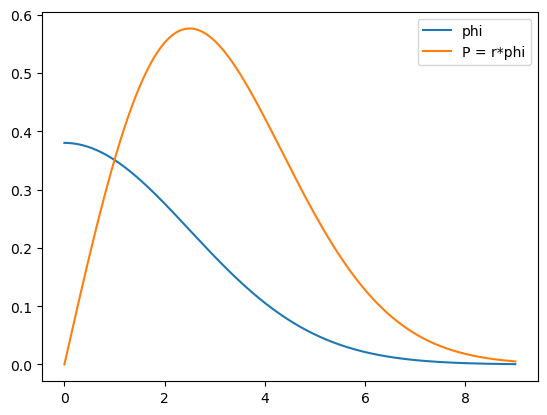

In [3]:
# We start initializing the wave function *r  
import math

#initialize the variables to the eRperiment desired
var = variables(3)

a0 = var.a0()  # scattering length in h.o. units
n1 = var.n1()  # numvber of intergation steps in r-grid
step = var.step()  # step size in r-grid
aa = var.aa()   # number of atoms
time = var.time() # timestep
alpha = var.alpha()  # starting parameter of the h.o. function
iter = var.iter()  # number of iterations


#construct the wave function, the P= phi*r function and the linspace of r
C = (np.sqrt(alpha)**3)/np.sqrt(np.sqrt(np.pi))


phi_ini = np.array([2*C*math.exp(-0.5*(alpha**2)*((step*i)**2)) for i in range(n1+1)])
R = np.linspace(0, n1*step, n1+1)
P_ini = phi_ini*R

P = P_ini
phi = phi_ini

plt.plot(R, phi_ini, label='phi')

plt.plot(R, P_ini, label = 'P = r*phi')

plt.legend()

plt.show()

In [4]:
#checking if the simpson integrator works as expected 

simpson_integration(P**2, step)

0.9999909356400294

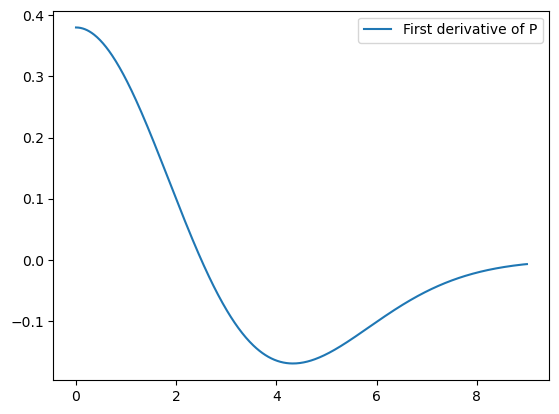

In [5]:
P_der = first_derivative(P, step)
plt.plot(R, P_der, label = 'First derivative of P')
plt.legend()

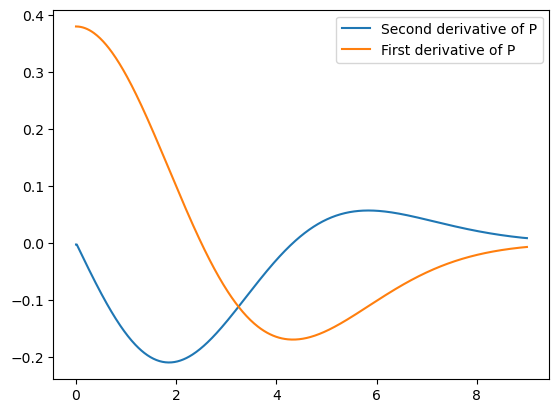

In [6]:
P_second_der = second_derivative(P, step)

plt.plot(R, P_second_der, label = 'Second derivative of P')
plt.plot(R, P_der, label = 'First derivative of P')

plt.legend()

In [7]:
class observables():

    def __init__(self, r_space, r_x_wave_func, step, scatter_l, N_atoms):
        self.P = r_x_wave_func
        self.r = r_space
        self.step = step
        self.wf_der = first_derivative(self.P, self.step)
        self.wf_secder = second_derivative(self.P, self.step)
        self.a_s = scatter_l
        self.N_atoms = N_atoms

    def radious2(self):
        radious2 = simpson_integration(f = ((self.P)**2)*((self.r)**2), step = self.step)
        return radious2
    
    def radious(self):
        return np.sqrt(self.radious2(self))
    
    def harmonic(self):
        harm = simpson_integration(f = ((self.P)**2)*((self.r)**2), step = self.step)
        return 0.5*harm
    
    def interaction(self):
        inter = simpson_integration(f = ((self.r)**2)*((self.P)**4), step = self.step)
        return self.a_s*self.N_atoms*0.5*inter
    
    def potential(self):
        inter = self.interaction(self)
        harm = self.harmonic(self)
        return self.a_s*self.N_atoms*0.5*inter+0.5*harm
    


    

In [8]:
measures = observables(r_space = R, r_x_wave_func= P, step = step, scatter_l = a0, N_atoms = aa)


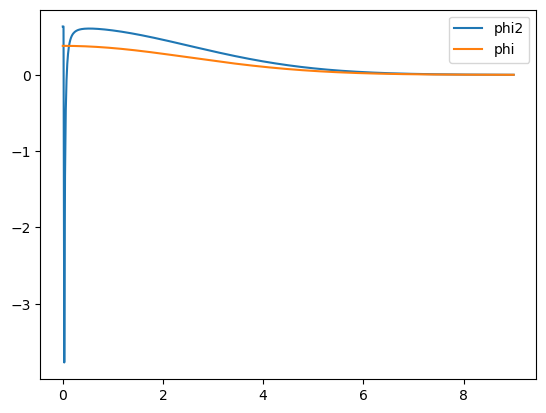

In [57]:

R_div = R
R_div[0] = 1e-10
phi = phi_ini
phi_secder = second_derivative(phi, step)
h = -0.5*(phi_secder/phi) + 0.5*(R_div**2) + a0*aa*(phi/R_div)**2
h[0:2] = 0
phi2 = phi - time*h*phi# + (time**2)*(h**2)*phi/2
phi2 = phi2/np.sqrt(simpson_integration(phi2**2, step))

plt.plot(R_div, phi2, label = 'phi2')
plt.plot(R_div, phi, label = 'phi')
plt.legend()

In [58]:
h

array([0.00000000e+00, 0.00000000e+00, 6.94781715e+04, 3.08736748e+04,
       1.73621025e+04, 1.11081764e+04, 7.71098377e+03, 5.66258559e+03,
       4.33309829e+03, 3.42160811e+03, 2.76962653e+03, 2.28723590e+03,
       1.92034030e+03, 1.63481129e+03, 1.40825484e+03, 1.22548273e+03,
       1.07589925e+03, 9.51930230e+02, 8.48045097e+02, 7.60129235e+02,
       6.85070228e+02, 6.20478587e+02, 5.64495230e+02, 5.15656222e+02,
       4.72796113e+02, 4.34977775e+02, 4.01440761e+02, 3.71562782e+02,
       3.44830650e+02, 3.20818105e+02, 2.99168722e+02, 2.79582620e+02,
       2.61806032e+02, 2.45623046e+02, 2.30849027e+02, 2.17325336e+02,
       2.04915053e+02, 1.93499510e+02, 1.82975442e+02, 1.73252651e+02,
       1.64252074e+02, 1.55904165e+02, 1.48147563e+02, 1.40927953e+02,
       1.34197123e+02, 1.27912157e+02, 1.22034753e+02, 1.16530640e+02,
       1.11369076e+02, 1.06522426e+02, 1.01965791e+02, 9.76766860e+01,
       9.36347685e+01, 8.98215961e+01, 8.62204180e+01, 8.28159919e+01,
      

xmu(i)=-0.5d0*fred(i)/freo(i) +0.5d0*xr2+cequ*(freo(i)/xr(i))**2

In [26]:
print(np.sqrt(simpson_integration(phi**2, step)))

0.565685333570924


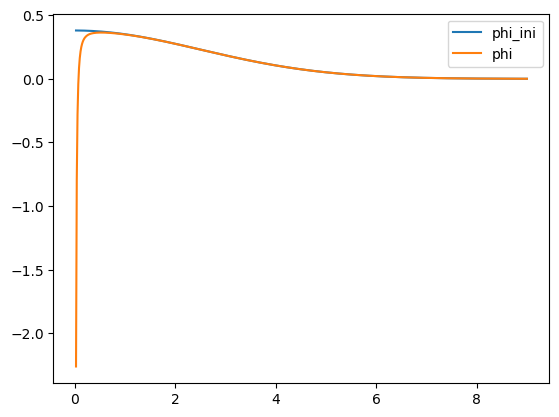

In [39]:
plt.plot(R[2:], phi_ini[2:], label='phi_ini')
plt.plot(R[2:], phi2[2:], label = 'phi')
plt.legend()